In [1]:
import pandas as pd

# Load from processed folder
train_df = pd.read_csv("../data/processed/train_processed.csv",index_col='Id')
test_df = pd.read_csv("../data/processed/test_processed.csv", index_col='Id')

# Preview
print("✅ Loaded data:")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

✅ Loaded data:
Train shape: (1460, 69)
Test shape: (1459, 68)


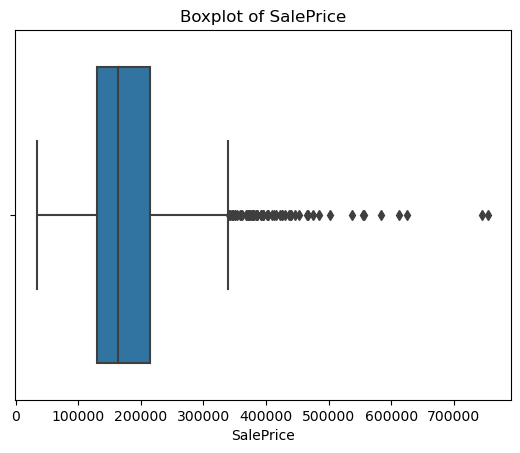

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=train_df['SalePrice'])
plt.title("Boxplot of SalePrice")
plt.show()


In [3]:
# Separate target variable
X = train_df.drop(columns=["SalePrice"])
y = train_df["SalePrice"]

## Stratified Sampling

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

# Create bins for stratification
y_bins = pd.qcut(y, q=10, labels=False)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y_bins
)

### Scaling features

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(test_df)

## Model Building

#### ✅ Step 1: Define Evaluation Function

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"📊 {model_name} Performance")
    print("-" * 30)
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")
    print()
    
    return {"model": model_name, "MAE": mae, "RMSE": rmse, "R2": r2}


In [7]:
results = []

In [8]:
from sklearn.linear_model import LinearRegression

# Train model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = lr.predict(X_val_scaled)

# Evaluate
lr_results = evaluate_model(y_val, y_pred_lr, model_name="Linear Regression")
results.append(lr_results)

📊 Linear Regression Performance
------------------------------
MAE  : 22031.55
RMSE : 33276.75
R²   : 0.8354



In [9]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Step 1: Define the degree of polynomial features with Regularization
degree = 2  # Try 2 or 3; higher degrees risk overfitting

# Step 2: Create pipeline
ridge_model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=10))
])

param_grid = {
    "ridge__alpha": [ 1, 3,10,30, 100, 300, 1000, 3000, 10000]
}

# Grid Search on Lasso pipeline
grid_ridge = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train_scaled, y_train)


# Best model
best_ridge = grid_ridge.best_estimator_
y_pred_best = best_ridge.predict(X_val_scaled)

print("Best alpha:", grid_ridge.best_params_['ridge__alpha'])
ridge_results = evaluate_model(y_val, y_pred_best, model_name="Best Polynomial Ridge")
results.append(ridge_results)


Best alpha: 1000
📊 Best Polynomial Ridge Performance
------------------------------
MAE  : 22176.64
RMSE : 33696.69
R²   : 0.8312



In [10]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


# Lasso Pipeline (Polynomial degree 2)
lasso_model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=3000,max_iter=5000))  # Start with small alpha
])

In [11]:
from sklearn.model_selection import GridSearchCV

# Grid for alpha values
param_grid = {
    "lasso__alpha": [ 1000, 3000, 10000, 30000]
}

# Grid Search on Lasso pipeline
grid_lasso = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_lasso.fit(X_train_scaled, y_train)

# Best model
best_lasso = grid_lasso.best_estimator_
y_pred_best = best_lasso.predict(X_val_scaled)

print("Best alpha:", grid_lasso.best_params_['lasso__alpha'])
lasso_results = evaluate_model(y_val, y_pred_best, model_name="Best Polynomial Lasso")
results.append(lasso_results)


Best alpha: 3000
📊 Best Polynomial Lasso Performance
------------------------------
MAE  : 19487.77
RMSE : 30753.11
R²   : 0.8594



In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid_dt = {
    'max_depth': [3, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_dt,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

# Best model
best_dt = grid_dt.best_estimator_
y_pred_best_dt = best_dt.predict(X_val)

# Evaluate
dt_results = evaluate_model(y_val, y_pred_best_dt, model_name="Tuned Decision Tree")
print("📌 Best params (DT):", grid_dt.best_params_)
results.append(dt_results)

📊 Tuned Decision Tree Performance
------------------------------
MAE  : 25086.19
RMSE : 38125.27
R²   : 0.7839

📌 Best params (DT): {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [13]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_val)

rf_results = evaluate_model(y_val, y_pred_best_rf, model_name="Tuned Random Forest")
print("📌 Best params (RF):", grid_rf.best_params_)
results.append(rf_results)


📊 Tuned Random Forest Performance
------------------------------
MAE  : 17050.17
RMSE : 28036.24
R²   : 0.8831

📌 Best params (RF): {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [14]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [15]:
from xgboost import XGBRegressor

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

grid_xgb = GridSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_val)

xgb_results = evaluate_model(y_val, y_pred_best_xgb, model_name="Tuned XGBoost")
print("📌 Best params (XGB):", grid_xgb.best_params_)
results.append(xgb_results)

📊 Tuned XGBoost Performance
------------------------------
MAE  : 15355.05
RMSE : 27081.29
R²   : 0.8910

📌 Best params (XGB): {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [16]:
import plotly.express as px

# Convert to DataFrame and melt
df_results = pd.DataFrame(results)
df_melted = df_results.melt(id_vars='model', var_name='Metric', value_name='Score')

# Plotly interactive bar chart
fig = px.bar(df_melted, 
             x='model', 
             y='Score', 
             color='Metric', 
             barmode='group',
             text='Score',
             hover_data={'Score': ':.4f'})

fig.update_layout(
    title='Model Performance Comparison',
    yaxis=dict(range=[0, 1.05]),
    hovermode='x unified'
)

fig.show()

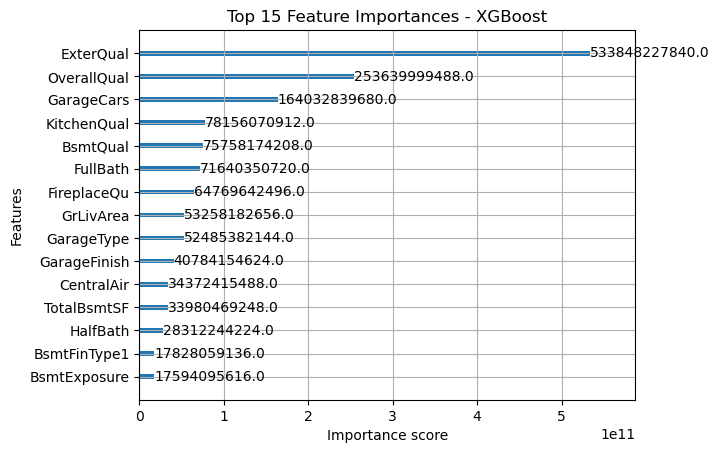

In [17]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(best_xgb, max_num_features=15, importance_type='gain')
plt.title("Top 15 Feature Importances - XGBoost")
plt.show()

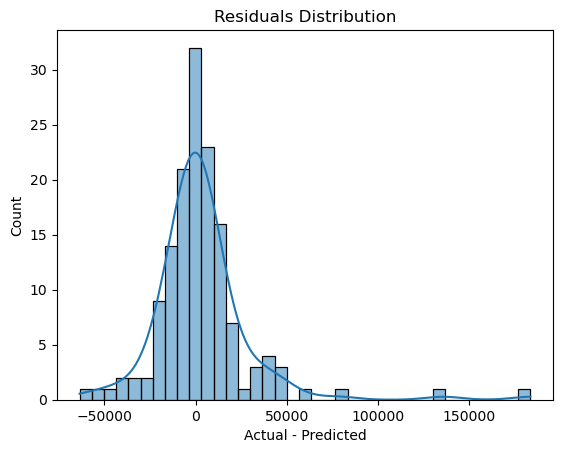

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_val - y_pred_best_xgb

sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Actual - Predicted")
plt.show()

In [19]:
val_results = X_val.copy()
val_results['Actual'] = y_val
val_results['Predicted'] = y_pred_best_xgb
val_results['Residual'] = val_results['Actual'] - val_results['Predicted']
val_results['AbsResidual'] = abs(val_results['Residual'])

In [20]:
val_results_sorted = val_results.sort_values(by='AbsResidual', ascending=False)
val_results_sorted.head(5)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Actual,Predicted,Residual,AbsResidual
Id,,,,,,,,,,,,,,,,,,,,,
899,20,3,100.0,12919,1,0,3,4,0,16,...,0,0,3,2010,6,5,611657,428086.718750,183570.281250,183570.281250
179,20,3,63.0,17423,1,0,3,1,0,22,...,0,0,7,2009,6,5,501837,366120.312500,135716.687500,135716.687500
665,20,3,49.0,20896,1,1,3,1,0,21,...,0,0,1,2006,6,5,423000,344728.437500,78271.562500,78271.562500
745,120,3,41.0,5395,1,0,1,4,0,22,...,0,0,10,2008,8,4,180000,243590.515625,-63590.515625,63590.515625
865,20,1,72.0,8640,1,3,3,4,0,21,...,0,0,5,2008,6,5,250580,193228.609375,57351.390625,57351.390625


In [21]:
# Get the indices
worst_idx = val_results_sorted.head(5).index

# Inspect original data
train_df.loc[worst_idx, ['SalePrice'] + list(X_val.columns)]

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
899,611657,20,3,100.0,12919,1,0,3,4,0,...,67,0,0,0,0,0,3,2010,6,5
179,501837,20,3,63.0,17423,1,0,3,1,0,...,60,0,0,0,0,0,7,2009,6,5
665,423000,20,3,49.0,20896,1,1,3,1,0,...,267,0,0,0,0,0,1,2006,6,5
745,180000,120,3,41.0,5395,1,0,1,4,0,...,0,70,168,0,0,0,10,2008,8,4
865,250580,20,1,72.0,8640,1,3,3,4,0,...,140,0,0,0,0,0,5,2008,6,5


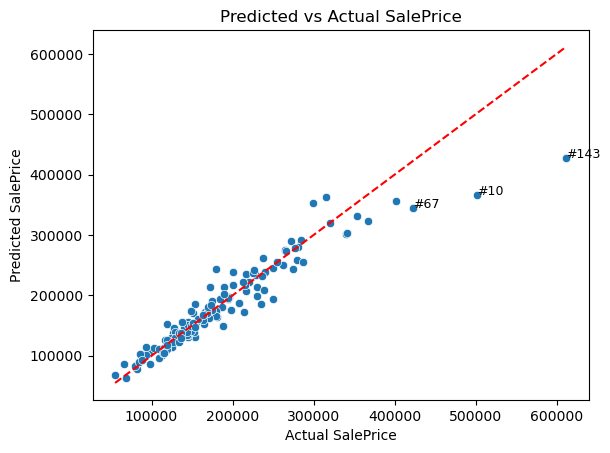

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index for proper alignment
y_val_reset = y_val.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred_best_xgb).reset_index(drop=True)

# Recreate val_results to match index positions
val_results = X_val.reset_index(drop=True).copy()
val_results['Actual'] = y_val_reset
val_results['Predicted'] = y_pred_reset
val_results['Residual'] = val_results['Actual'] - val_results['Predicted']
val_results['AbsResidual'] = val_results['Residual'].abs()

# Get worst residual positions (not index)
worst_positions = val_results['AbsResidual'].nlargest(3).index

# Plot
sns.scatterplot(x=y_val_reset, y=y_pred_reset)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs Actual SalePrice")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')

# Annotate the worst outliers
for i in worst_positions:
    plt.text(y_val_reset[i], y_pred_reset[i], f"#{i}", fontsize=9)

plt.show()

## 🔍 Future Work: Handling Large Residuals

While the tuned **XGBoost model** achieved strong overall performance (`R² = 0.891`, `MAE ≈ 15K`, `RMSE ≈ 27K`), a few samples exhibited unusually large residuals (e.g., +150K or –50K). These outliers may indicate model blind spots or rare property configurations.

---

### 🧠 Potential Causes

- Homes with **extreme feature values** (e.g., very large `GrLivArea`, `GarageArea`, or `PoolArea`)
- Uncommon combinations of features (e.g., finished basements + multiple fireplaces + 3-season porches)
- Data points with **errors or rare categories** that are underrepresented

---

### ✅ Proposed Follow-Up Actions

1. **Investigate Outliers Manually**
   - Use residual plots to identify top 3–5 highest error predictions
   - Review full feature values for these homes to understand what makes them difficult to predict

2. **Transform Target Variable**
   - Apply a log transformation (`log1p(SalePrice)`) to reduce skew and stabilize variance
   - Can improve RMSE by reducing the impact of large absolute errors

3. **Trim or Cap Outliers**
   - Optionally remove homes above the 99th percentile of `SalePrice`
   - Or use a robust loss function (e.g., Huber loss) that’s less sensitive to outliers

4. **Feature Engineering for Luxury Indicators**
   - Create boolean flags like `HasPool`, `Has3SsnPorch`, or `IsLuxuryHome`
   - Bin or scale extreme numeric features (e.g., `GrLivArea`, `TotalBsmtSF`)

5. **Use Quantile Regression or Ensembling**
   - Predict uncertainty bounds using quantile regression models
   - Blend models like Lasso + XGBoost + SVR for better generalization

---

> 📌 *Note:* Outliers in regression are not always bad data — they may represent genuine, but rare homes. Properly addressing them can significantly improve both predictive accuracy and model trustworthiness.

In [23]:
import os

y_pred = best_xgb.predict(test_df)
print(y_pred)
submission_df = pd.DataFrame({
    "Id": test_df.index,
    "SalePrice": y_pred
})

import os

if os.path.exists("../outputs") and os.path.isdir("../outputs"):
    print("✅ 'outputs' folder already exists.")
else:
    os.mkdir('../outputs')
submission_df.to_csv("..\outputs\submission.csv", index=False)


[132351.8  165172.95 159433.83 ... 169514.38 132936.94 222657.75]
✅ 'outputs' folder already exists.
